In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Visualization block <br>

Assuming the best trained model will exactly replicate the training dataset, the objective is to anticipate how the addition of the (additional) error term will affect the loss function behavior. 

<h4> Surface Pressure data

In [2]:
outDS = xr.open_dataset('./data/aibedo_data/compress.isosph.CESM2.historical.r1i1p1f1.Output.nc')
meanDS = xr.open_dataset('./data/aibedo_data/ymonmean.1980_2010.isosph.CMIP6.historical.ensmean.Output.nc')
stdDS = xr.open_dataset('./data/aibedo_data/ymonstd.1980_2010.isosph.CMIP6.historical.ensmean.Output.nc')

In [3]:
PE_err = "./data/aibedo_data/CMIP6_PE_clim_err.isoph6.npy"
PE_std = "./data/aibedo_data/CMIP6_PE_clim_std.isoph6.npy"
PS_err = "./data/aibedo_data/CMIP6_PS_clim_err.isoph6.npy"
PS_std = "./data/aibedo_data/CMIP6_PS_clim_std.isoph6.npy"

PE_err = np.load(PE_err)
PE_std = np.load(PE_std)
PS_err = np.load(PS_err)
PS_std = np.load(PS_std)

In [4]:
val = 'ps_pre'
unscaled_val = 'ps'
stat = 'ps'

In [5]:
ps_scaled = outDS[val].data

ps_std = stdDS.ps.data 
ps_mean = meanDS.ps.data

lon_list = outDS.lon.data
lat_list = outDS.lat.data

In [6]:
print(ps_scaled.shape)
print(ps_std.shape)
print(ps_mean.shape)

(1980, 40962)
(12, 40962)
(12, 40962)


<h4> Need to convert 1980 monthly timesteps into yearly timesteps with 12 month period to denorm

In [7]:
splitedSize = 12
ps_splited = [ps_scaled[x:x+splitedSize] for x in range(0, len(ps_scaled), splitedSize)]
print(len(ps_splited))
print(ps_splited[1].shape)

165
(12, 40962)


In [8]:
ps_avg = np.zeros((len(ps_splited), ps_splited[1].shape[0]))
ps_unscaled = np.full_like(ps_splited,0)
ps_val = np.full_like(ps_avg,0)
for i in range(len(ps_splited)):
    for j in range(ps_splited[1].shape[0]):
        ps_unscaled[i,j,:] = ps_splited[i][j]*ps_std[j,:] + ps_mean[j,:]
        ps_avg[i,j] = np.mean(ps_unscaled[i][j])
        ps_val[i,j] = ps_avg[i,j] - PS_err[j]

In [9]:
ps_val_mean = np.zeros(12)
for i in range(12):
    ps_val_mean[i] = np.mean(ps_val[:,i])

<h4> Plotting Ps_val after denorm and subtracting Ps_err, on a monthly averaged basis

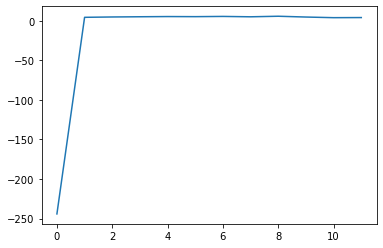

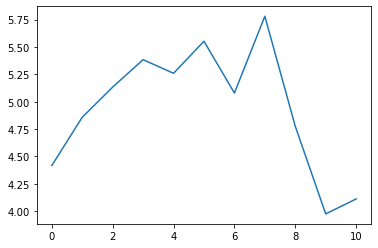

In [10]:
plt.plot(ps_val_mean)
plt.figure()
plt.plot(ps_val_mean[1:])

<h4> Note: The January value is unreasonably higher. Rest of the months have reasonable values

In [11]:
ps_unscaled_Orig = outDS[unscaled_val].data

In [12]:
ps_unscaled_Orig.shape

(1980, 40962)

In [13]:
splitedSize = 12
ps_unscaled_splited = [ps_unscaled_Orig[x:x+splitedSize] for x in range(0, len(ps_unscaled_Orig), splitedSize)]
print(len(ps_unscaled_splited))
print(ps_unscaled_splited[1].shape)

165
(12, 40962)


In [14]:
t1 = 10 # in years
t2 = 0 # months between 0-11

In [15]:
diff = ps_unscaled_splited - ps_unscaled

In [16]:
diff.shape

(165, 12, 40962)

In [17]:
100*np.min(diff)/np.max(ps_unscaled_splited[t1][t2])

-7.071734744501154

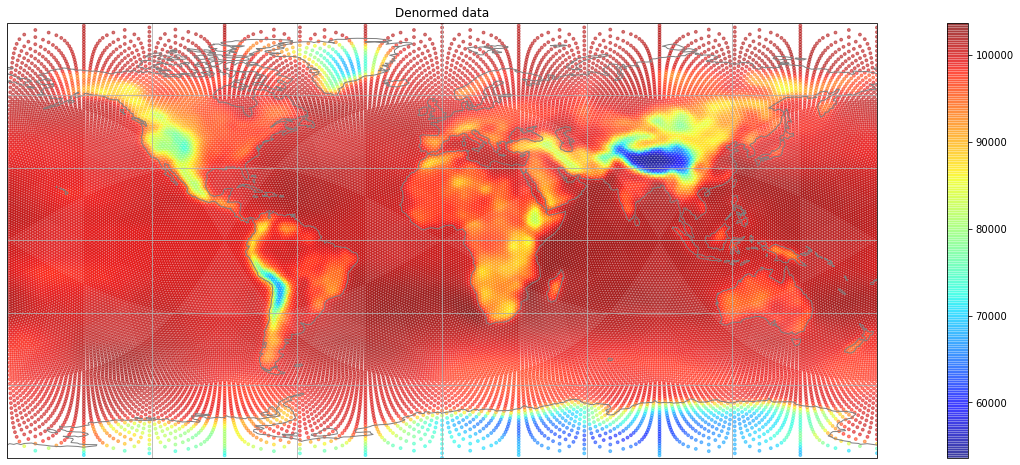

In [27]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=ps_unscaled[t1,t2,:],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Denormed data")

plt.show()

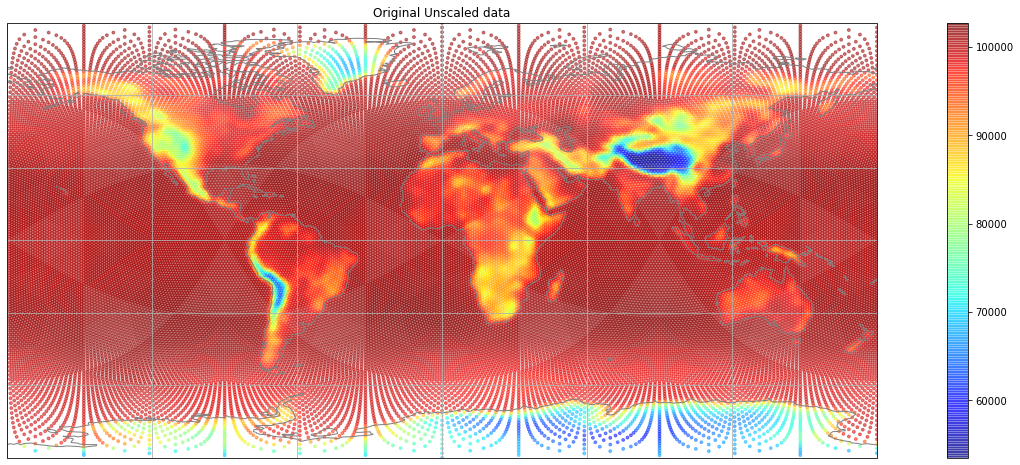

In [25]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=ps_unscaled_splited[t1][t2],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Original Unscaled data")

plt.show()

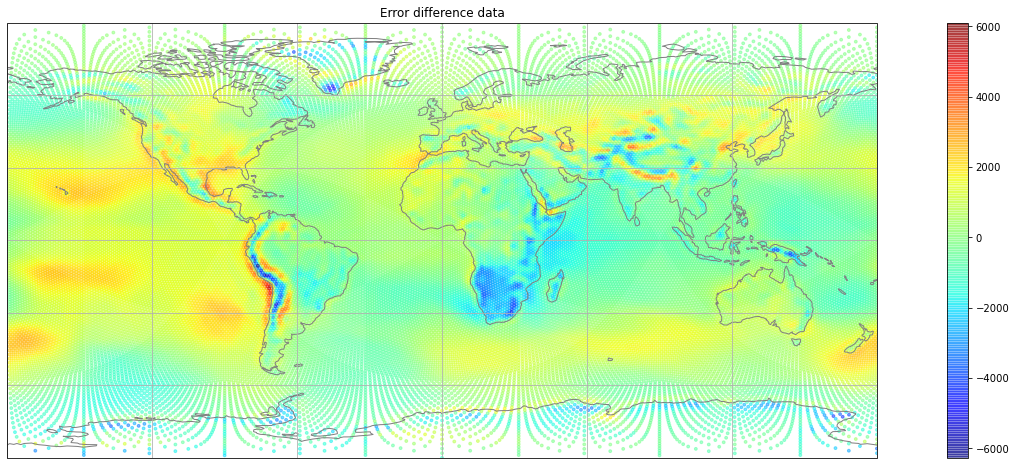

In [24]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=diff[t1,t2,:],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Error difference data")

plt.show()

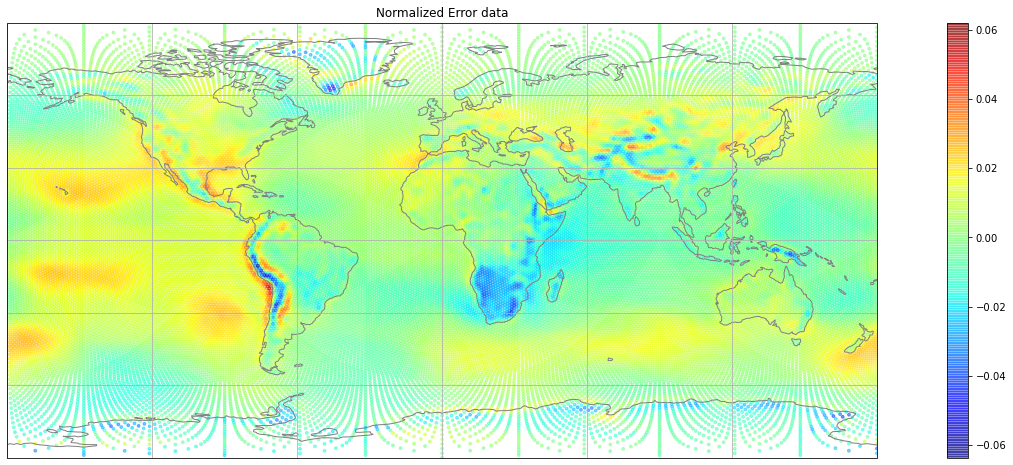

In [22]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=diff[t1,t2,:]/np.max(PS_err),
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Normalized Error data")

plt.show()

<h4> Moisture budget

In [68]:
evap = 'evspsbl_pre'
precip = 'pr_pre'

In [69]:
evap_scaled = outDS[evap].data
precip_scaled = outDS[precip].data

pr_std = stdDS.pr.data 
pr_mean = meanDS.pr.data

evap_std = stdDS.evspsbl.data 
evap_mean = meanDS.evspsbl.data

lon_list = outDS.lon.data
lat_list = outDS.lat.data

In [70]:
splitedSize = 12
precip_splited = [precip_scaled[x:x+splitedSize] for x in range(0, len(precip_scaled), splitedSize)]
evap_splited = [evap_scaled[x:x+splitedSize] for x in range(0, len(evap_scaled), splitedSize)]

In [71]:
precip_unscaled = np.full_like(precip_splited,0)
evap_unscaled = np.full_like(evap_splited,0)

precip_avg = np.zeros((len(precip_splited), precip_splited[1].shape[0]))
evap_avg = np.zeros((len(evap_splited), evap_splited[1].shape[0]))

val = np.full_like(precip_avg,0)

In [72]:
precip_unscaled.shape

(165, 12, 40962)

In [73]:
for i in range(precip_unscaled.shape[0]): #165 years
    for j in range(precip_unscaled.shape[1]): # 12 months
        precip_unscaled[i, j, :] = precip_splited[i][j] * pr_std[j,:] + pr_mean[j,:]
        evap_unscaled[i, j, :] = evap_splited[i][j] * evap_std[j,:] + evap_mean[j,:]
        precip_avg[i,j] = np.mean(precip_unscaled[i,j,:]) # on a monthly basis
        evap_avg[i,j]   = np.mean(evap_unscaled[i,j,:]) # on a monthly basis
        val[i,j] = precip_avg[i,j] - evap_avg[i,j] - PE_err[j] # on a monthly basis

In [74]:
for i in range(precip_unscaled.shape[0]): #165 years
    for j in range(precip_unscaled.shape[1]): # 12 months
        print(np.max(val[i,j]))

-7.264541892482157e-07
-5.105484248701941e-07
-9.720019384928946e-07
-7.344262087372044e-07
-1.059656057122993e-06
-5.658838801991806e-07
-6.239595222723437e-07
-5.037900052684563e-07
-4.879520645317825e-07
-3.2512679126739386e-07
-4.035605911667517e-07
-6.392300235802395e-07
1.8096322662586317e-07
-1.6929873680737728e-07
-2.9585811134325013e-07
-1.8243568433717883e-07
4.582360304539179e-07
-1.256884445410833e-07
4.770383839058923e-07
2.570277786162478e-07
1.1373688835192297e-07
-1.7105475080825272e-07
-2.800476295305998e-08
1.252075122692986e-06
1.7659469193631594e-06
1.2982037063125063e-06
1.5556184429499353e-06
1.1915561515252193e-06
2.9233268321604555e-06
1.2034180087994173e-06
1.5718226222816156e-06
1.6039894319419545e-06
3.7727207313764666e-07
6.656439950347703e-07
1.1195083402526507e-06
9.370443478928792e-07
9.256756783315723e-07
1.242735443440779e-06
1.6627641947764005e-06
8.594196003741672e-07
1.2012095282898372e-06
6.543124015934154e-07
4.829282715945737e-07
1.283488302306068

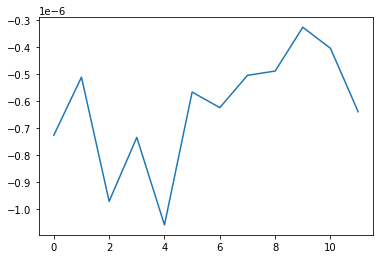

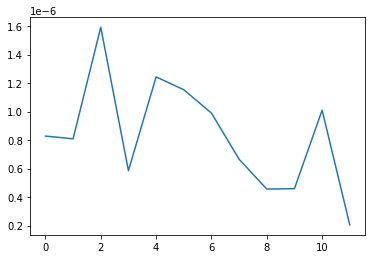

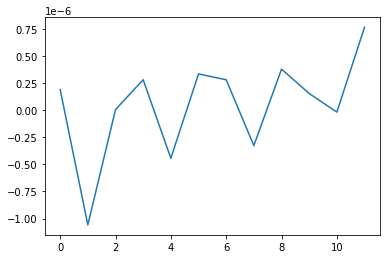

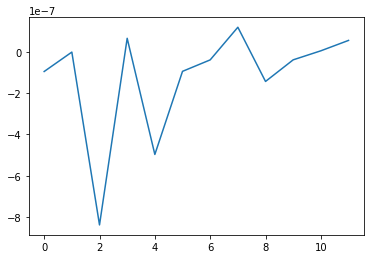

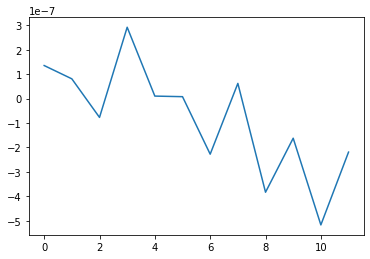

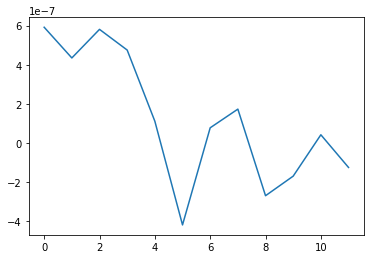

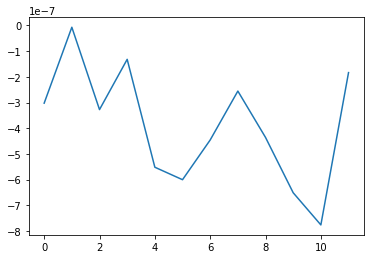

In [75]:
test = [0, 5, 10, 56, 120, 155, 164]

for i in test:
    plt.figure()
    plt.plot(val[i,:])


<h4> Values are close to machine precision!

In [76]:
evap = 'evspsbl'
precip = 'pr'

In [77]:
evap_unscaled_orig = outDS[evap].data
precip_unscaled_orig = outDS[precip].data

In [78]:
splitedSize = 12
precip_splited_unscaled = [precip_unscaled_orig[x:x+splitedSize] for x in range(0, len(precip_unscaled_orig), splitedSize)]
evap_splited_unscaled = [evap_unscaled_orig[x:x+splitedSize] for x in range(0, len(evap_unscaled_orig), splitedSize)]

In [79]:
print(len(precip_splited_unscaled))
print(precip_unscaled.shape)

165
(165, 12, 40962)


In [80]:
diff = precip_unscaled - precip_splited_unscaled

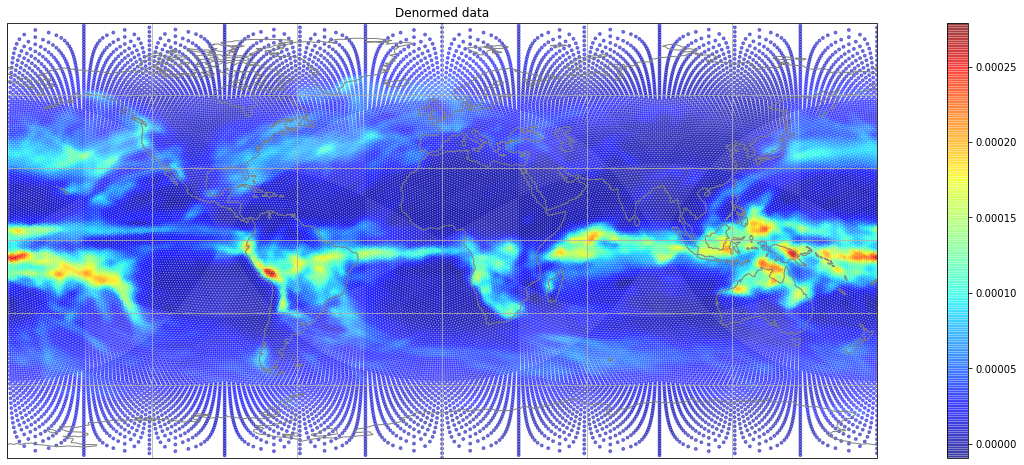

In [86]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=precip_unscaled[t1,t2,:],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Denormed data")

plt.show()

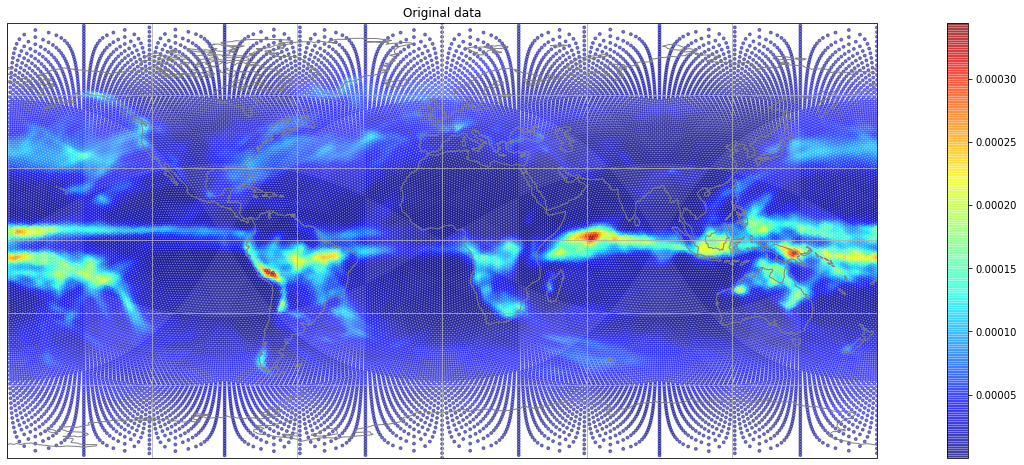

In [87]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=precip_splited_unscaled[t1][t2],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Original data")

plt.show()

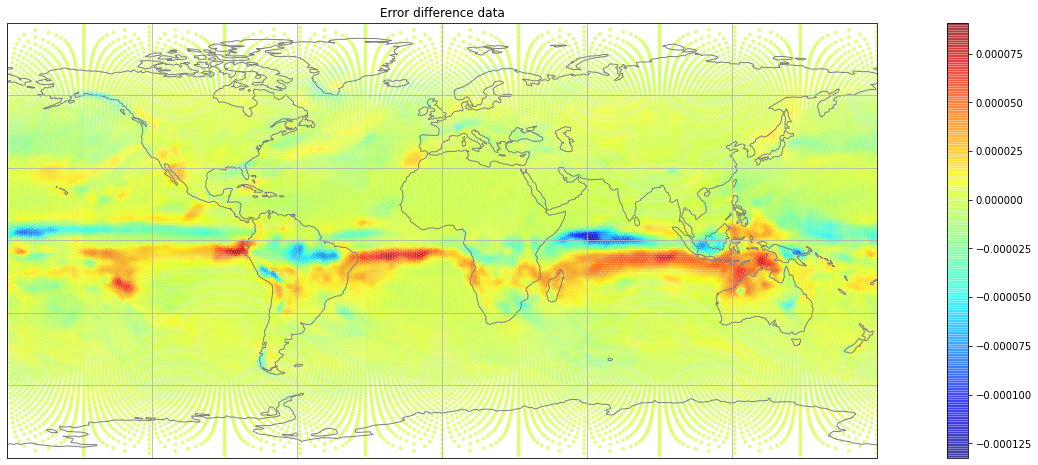

In [88]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=diff[t1,t2,:],
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Error difference data")

plt.show()

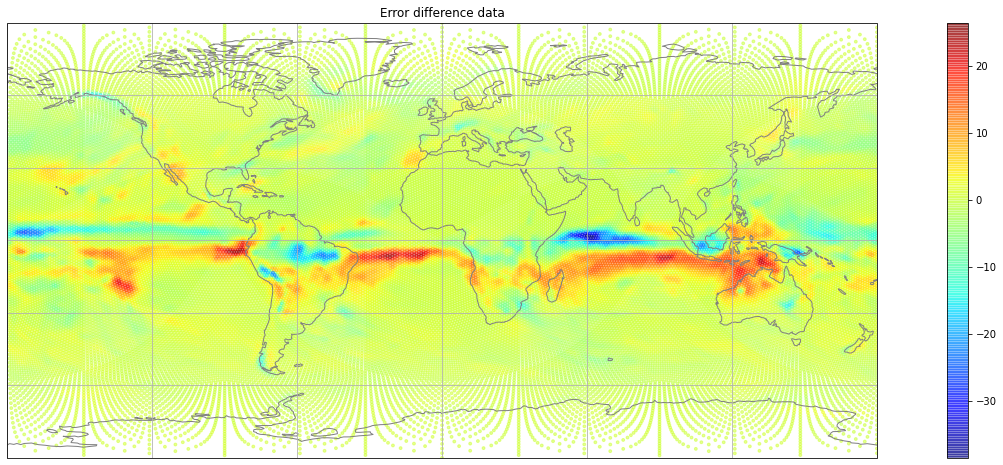

In [90]:
fig = plt.figure(figsize=(25,8))

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

ax.set_global()

ax.add_feature(cfeature.COASTLINE, edgecolor="grey")
#ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()

v = plt.scatter(x=lon_list, y=lat_list,
            c=100*diff[t1,t2,:]/np.max(precip_splited_unscaled[t1][t2]),
            s=8,
            alpha=0.5,
            cmap='jet',
            transform=crs.PlateCarree()) ## Important
#plt.clim(0.0003, 0.0004) # only for precip
#plt.clim(96000, 104000) #for psl
plt.colorbar(v, ax=ax)
plt.title("Error difference data")

plt.show()

<h4> Error values are higher (~20-30%) in some locations 